In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', 50)

## Data loading

In [3]:
DATA_DIR = "../../titanic/"

train_df = pd.read_csv(DATA_DIR + 'train.csv', index_col='PassengerId')
y_train = train_df['Survived']

test_df = pd.read_csv(DATA_DIR + 'test.csv', index_col='PassengerId')

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
train_df[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


## Visualization

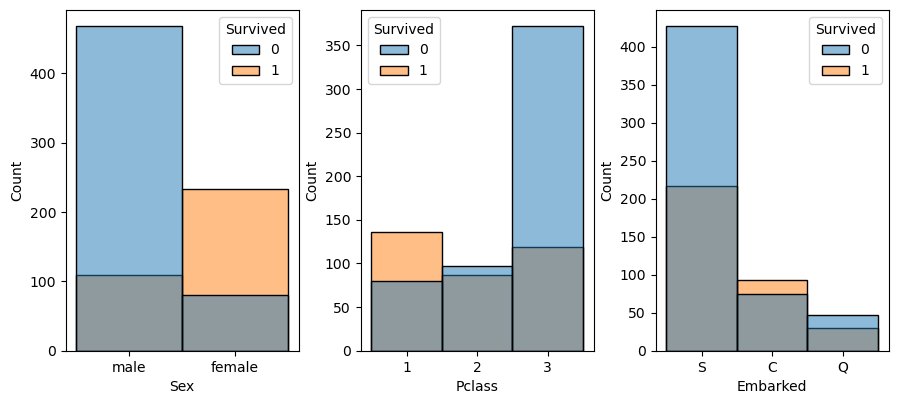

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(9,4))
fig.tight_layout()
sns.histplot(data=train_df, x='Sex', hue='Survived', ax=ax[0])
sns.histplot(data=train_df, x='Pclass', hue='Survived', ax=ax[1], discrete=True)
sns.histplot(data=train_df, x='Embarked', hue='Survived', ax=ax[2]);

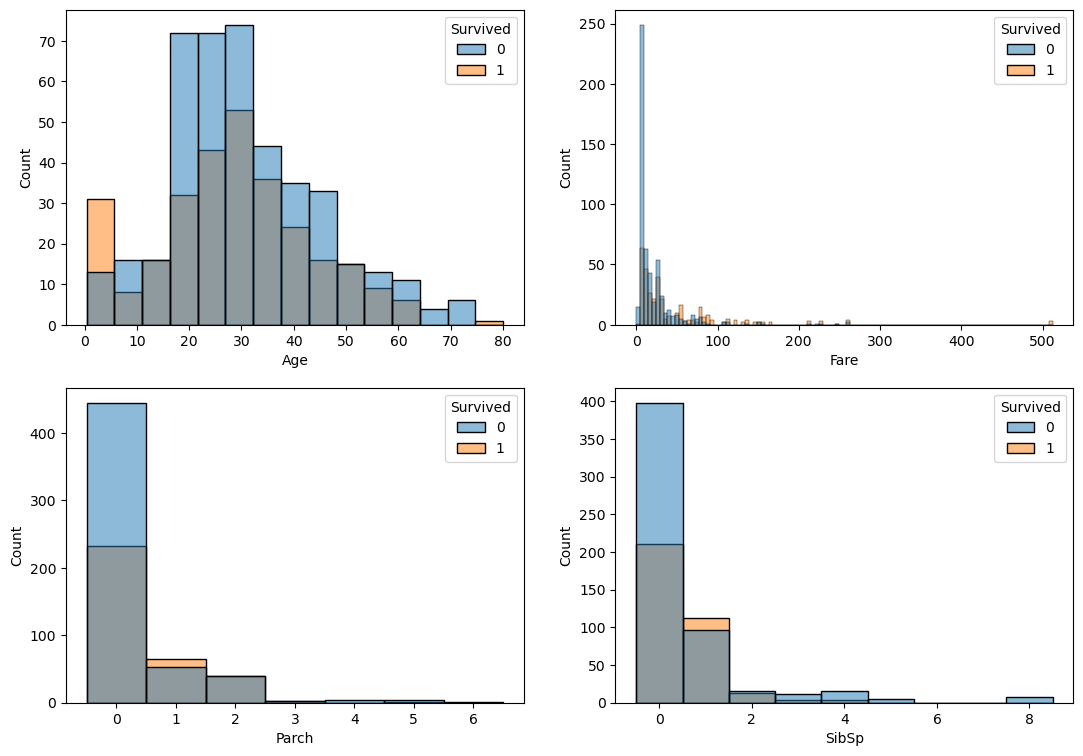

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(13,9))
sns.histplot(data=train_df, x='Age', hue='Survived', ax=ax[0][0], bins=15)
sns.histplot(data=train_df, x='Fare', hue='Survived', ax=ax[0][1])
sns.histplot(data=train_df, x='Parch', hue='Survived', ax=ax[1][0], discrete=True)
sns.histplot(data=train_df, x='SibSp', hue='Survived', ax=ax[1][1], discrete=True);

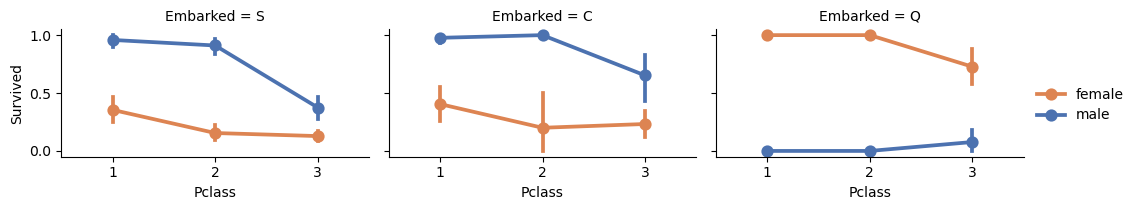

In [8]:
grid = sns.FacetGrid(train_df, col='Embarked', height=2.2, aspect=1.6)
grid.map_dataframe(sns.pointplot, x='Pclass', y='Survived', hue='Sex', palette='deep')
grid.add_legend();

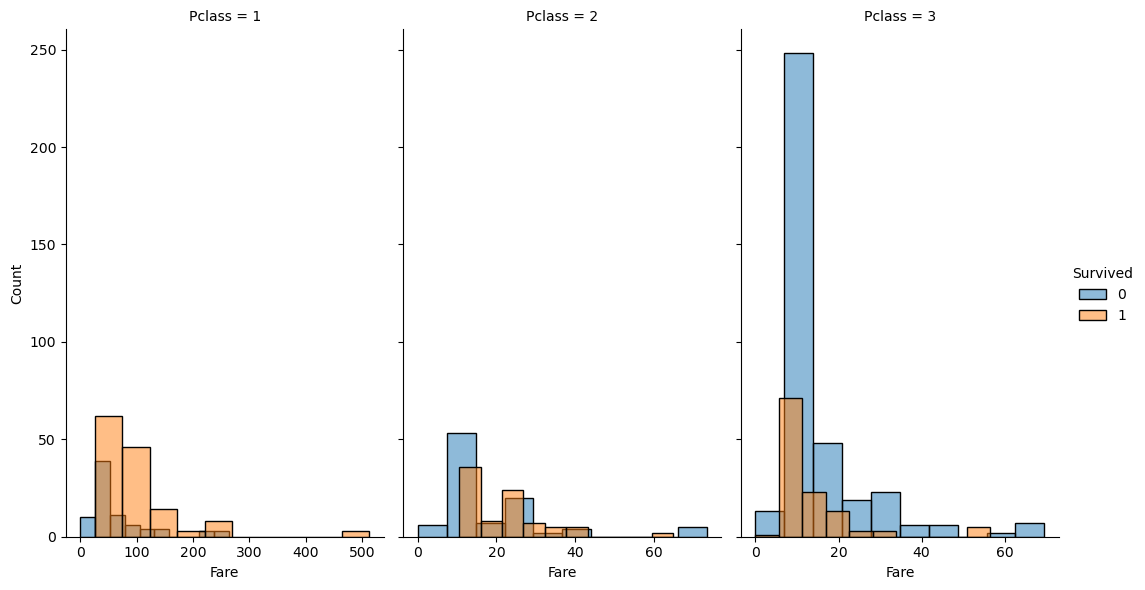

In [9]:
grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived', height=6, aspect=0.6, sharex=False)
grid.map_dataframe(sns.histplot, x='Fare', alpha=.5, bins=10)
grid.add_legend();

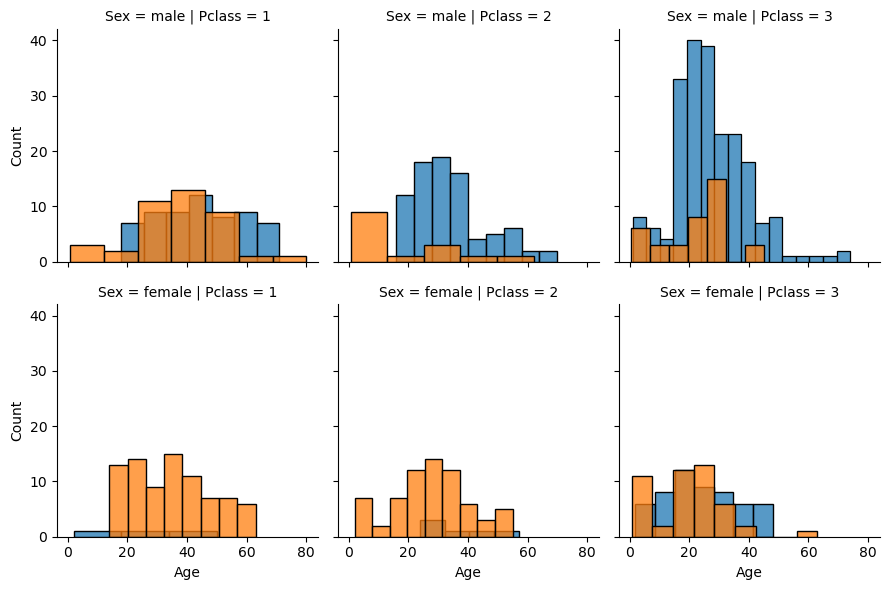

In [10]:
sex_pclass_grid = sns.FacetGrid(train_df, row='Sex', col='Pclass', hue='Survived')
sex_pclass_grid.map_dataframe(sns.histplot, x='Age');

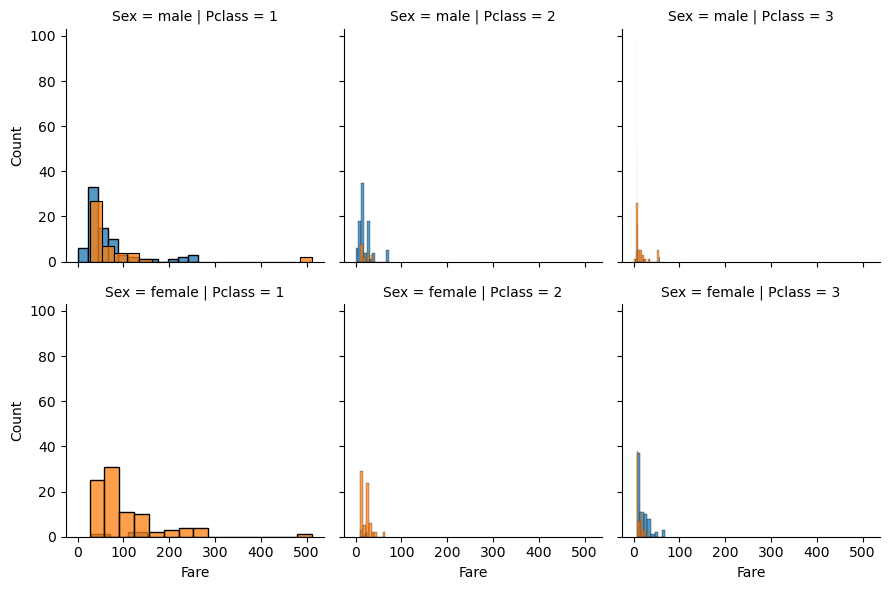

In [11]:
sex_pclass_grid = sns.FacetGrid(train_df, row='Sex', col='Pclass', hue='Survived')
sex_pclass_grid.map_dataframe(sns.histplot, x='Fare');

## Data wrangling

In [7]:
X_train = train_df.drop('Survived', axis=1).copy()
X_test = test_df.copy()

In [8]:
X_train['FamilySize'] = (X_train['SibSp'] + X_train['Parch'] + 1)
X_test['FamilySize'] = (X_test['SibSp'] + X_test['Parch'] + 1)

In [9]:
fare_train_median = X_train['Fare'].dropna().median()
X_train['Fare'] = X_train['Fare'].fillna(fare_train_median)
X_test['Fare'] = X_test['Fare'].fillna(fare_train_median)

In [10]:
fare_percentile_bins = pd.qcut(X_train['Fare'], 4, retbins=True)[1]
fare_percentile_bins

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [11]:
X_train['Fare_1_49_Perc'] = (X_train['Fare'] <= 10.5).astype('int')
X_train['Fare_50_89_Perc'] = ((X_train['Fare'] > 10.5) & (X_train['Fare'] <= 77.958)).astype('int')

X_test['Fare_1_49_Perc'] = (X_test['Fare'] <= 10.5).astype('int')
X_test['Fare_50_89_Perc'] = ((X_test['Fare'] > 10.5) & (X_test['Fare'] <= 77.958)).astype('int')

X_train['FareBin'] = pd.cut(X_train['Fare'], bins=fare_percentile_bins, labels=False, include_lowest=True)
X_test['FareBin'] = pd.cut(X_test['Fare'], bins=fare_percentile_bins, labels=False, include_lowest=True)

In [12]:
embarked_train_mode = X_train['Embarked'].dropna().mode()[0]
X_train['Embarked'] = X_train['Embarked'].fillna(embarked_train_mode)
X_test['Embarked'] = X_test['Embarked'].fillna(embarked_train_mode)

In [13]:
def impute_age(df, stats):
    for (sex, pclass), row in stats.iterrows():
        mean, std = row['mean'], row['std']
        mask = (df['Sex'] == sex) & (df['Pclass'] == pclass) & df['Age'].isna()
        df.loc[mask, 'Age'] = rng.normal(mean, std, mask.sum())

rng = np.random.default_rng(42)
age_stats_grouped = X_train.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'std'])

impute_age(X_train, age_stats_grouped)
impute_age(X_test, age_stats_grouped)

In [14]:
age_percentile_bins = pd.cut(X_train['Age'], 5, retbins=True)[1]
age_percentile_bins

array([ 0.34042, 16.336  , 32.252  , 48.168  , 64.084  , 80.     ])

In [15]:
X_train['IsChild'] = (X_train['Age'] <= 6).astype('int')
X_train['IsTeenager'] = ((X_train['Age'] > 7) & (X_train['Age'] <= 18)).astype('int')
X_train['IsAdult'] = ((X_train['Age'] > 18) & (X_train['Age'] <= 32)).astype('int')
X_train['IsMiddleAged'] = ((X_train['Age'] > 32) & (X_train['Age'] <= 48)).astype('int')

X_test['IsChild'] = (X_test['Age'] <= 6).astype('int')
X_test['IsTeenager'] = ((X_test['Age'] > 7) & (X_test['Age'] <= 18)).astype('int')
X_test['IsAdult'] = ((X_test['Age'] > 18) & (X_test['Age'] <= 32)).astype('int')
X_test['IsMiddleAged'] = ((X_test['Age'] > 32) & (X_test['Age'] <= 48)).astype('int')

X_train['AgeBin'] = pd.cut(X_train['Age'], bins=fare_percentile_bins, labels=False, include_lowest=True)
X_test['AgeBin'] = pd.cut(X_test['Age'], bins=fare_percentile_bins, labels=False, include_lowest=True)

In [16]:
X_train['Title'] = X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_57111/632215102.py:1: SyntaxWarning: invalid escape sequence '\.'
  X_train['Title'] = X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/tmp/ipykernel_57111/632215102.py:2: SyntaxWarning: invalid escape sequence '\.'
  X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [17]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
X_train['Title'] = X_train['Title'].replace(rare_titles, 'Rare')
X_test['Title'] = X_test['Title'].replace(rare_titles, 'Rare')

X_train['Title'] = X_train['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
X_test['Title'] = X_test['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

In [18]:
cols_to_dummy = ['Embarked', 'Title']
X_train = pd.get_dummies(X_train, columns=cols_to_dummy, drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=cols_to_dummy, drop_first=True, dtype='int')

In [19]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_train[['Age', 'Fare']] = standard_scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = standard_scaler.fit_transform(X_test[['Age', 'Fare']])

In [20]:
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1})
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})

In [21]:
cols_to_drop = ['Name', 'Ticket', 'Cabin']
X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

In [22]:
X_test = X_test.reindex(columns=X_train.columns)

In [23]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Fare_1_49_Perc,Fare_50_89_Perc,FareBin,IsChild,IsTeenager,IsAdult,IsMiddleAged,AgeBin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,0,-0.508320,1,0,-0.502445,2,1,0,0,0,0,1,0,2,0,1,0,1,0,0
2,1,1,0.626602,1,0,0.786845,2,0,1,3,0,0,0,1,3,0,0,0,0,1,0
3,3,1,-0.224590,0,0,-0.488854,1,1,0,1,0,0,1,0,2,0,1,1,0,0,0
4,1,1,0.413804,1,0,0.420730,2,0,1,3,0,0,0,1,3,0,1,0,0,1,0
5,3,0,0.413804,0,0,-0.486337,1,1,0,1,0,0,0,1,3,0,1,0,1,0,0


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           891 non-null    int64  
 1   Sex              891 non-null    int64  
 2   Age              891 non-null    float64
 3   SibSp            891 non-null    int64  
 4   Parch            891 non-null    int64  
 5   Fare             891 non-null    float64
 6   FamilySize       891 non-null    int64  
 7   Fare_1_49_Perc   891 non-null    int64  
 8   Fare_50_89_Perc  891 non-null    int64  
 9   FareBin          891 non-null    int64  
 10  IsChild          891 non-null    int64  
 11  IsTeenager       891 non-null    int64  
 12  IsAdult          891 non-null    int64  
 13  IsMiddleAged     891 non-null    int64  
 14  AgeBin           891 non-null    int64  
 15  Embarked_Q       891 non-null    int64  
 16  Embarked_S       891 non-null    int64  
 17  Title_Miss       891 

## Post-wrangling visualization

In [25]:
train_df_new = pd.concat([y_train, X_train], axis=1)

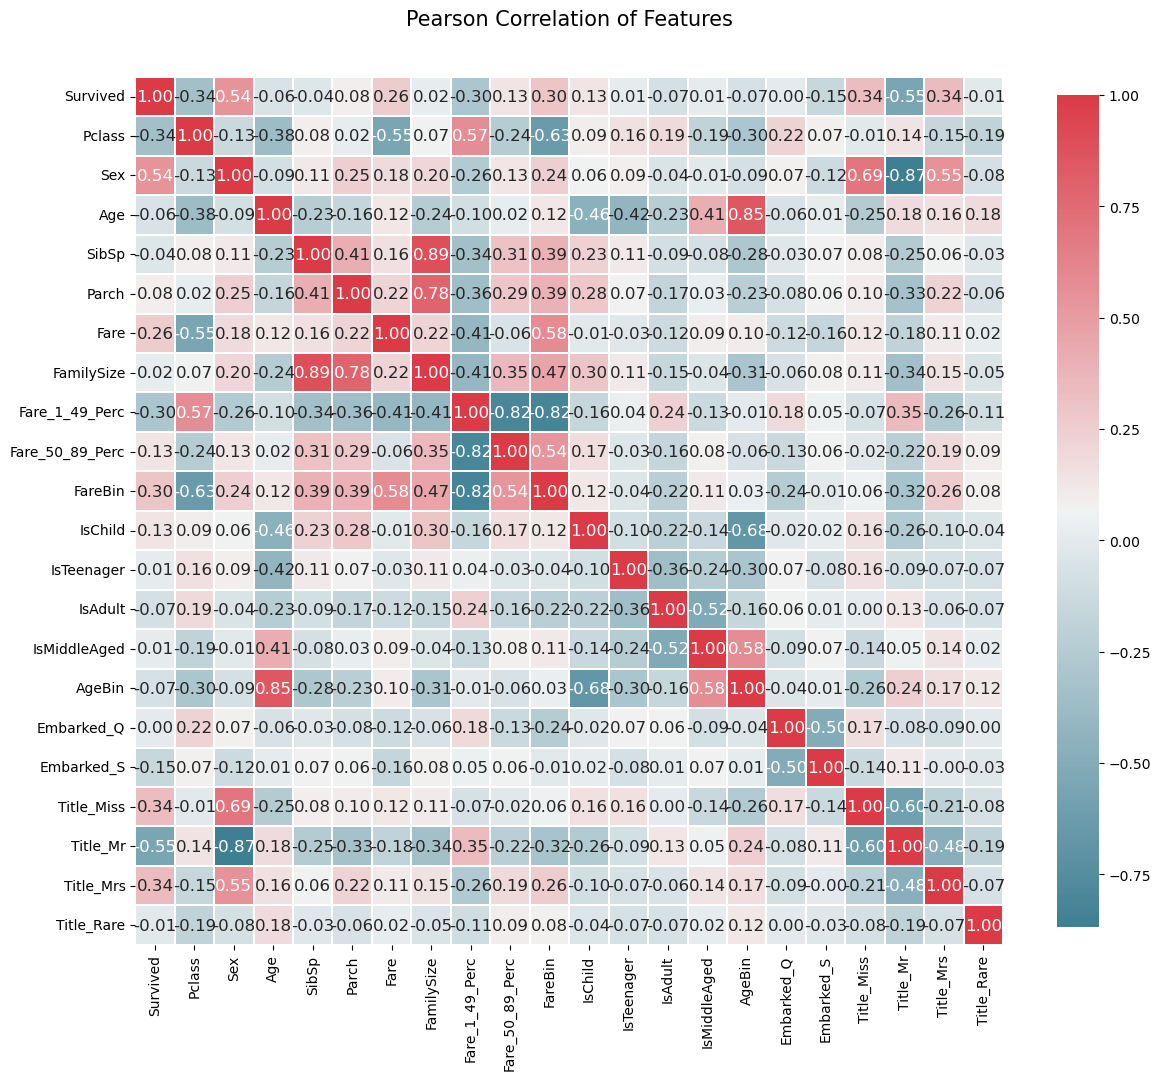

In [26]:
_ , ax = plt.subplots(figsize =(14, 12))   
sns.heatmap(
    train_df_new.corr(),
    square=True,
    cmap=sns.diverging_palette(220, 10, as_cmap = True),
    cbar_kws={'shrink':.9 },
    ax=ax,
    annot=True,
    fmt='.2f',
    linewidths=0.1,vmax=1.0, linecolor='white',
    annot_kws={'fontsize':12 }
)

plt.title('Pearson Correlation of Features', y=1.05, size=15);

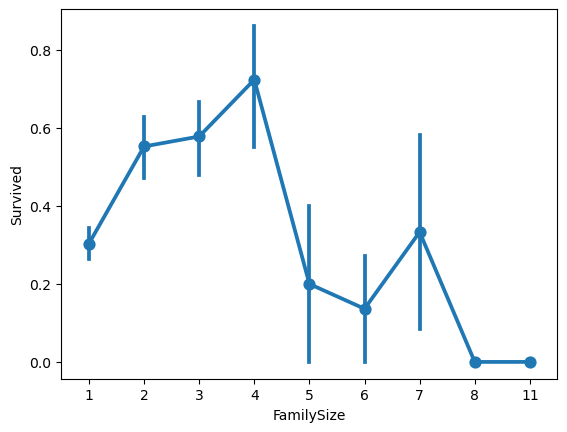

In [28]:
sns.pointplot(data=train_df_new, x='FamilySize', y='Survived');

In [299]:
train_df_new.groupby('Is_Child')['Survived'].mean()

Is_Child
0    0.367857
1    0.647059
Name: Survived, dtype: float64

## Model selection

In [55]:
models = {}

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print(f'Decision Tree: {dt.score(X_train, y_train) * 100:.4f}')
models['Decision Tree'] = dt

Decision Tree: 99.1021


In [57]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print(f'Random Forest: {rf.score(X_train, y_train) * 100:.4f}')
models['Random Forest'] = rf

Random Forest: 99.1021


In [58]:
xgbr = xgb.XGBClassifier(n_jobs=-1)
xgbr.fit(X_train, y_train)
print(f'XGB: {xgbr.score(X_train, y_train) * 100:.4f}')
models['XGB'] = xgbr

xgbrf = xgb.XGBRFClassifier(n_jobs=-1)
xgbrf.fit(X_train, y_train)
print(f'XGB RF: {xgbrf.score(X_train, y_train) * 100:.4f}')
models['XGB RF'] = xgbrf

XGB: 97.4186
XGB RF: 87.4299


In [59]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(f'Logistic Regression: {logreg.score(X_train, y_train) * 100:.4f}')
models['Logistic Regression'] = logreg

ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
print(f'Ridge Classifier: {ridge.score(X_train, y_train) * 100:.4f}')
models['Ridge Classifier'] = ridge

sgdc = SGDClassifier(random_state=42)
sgdc.fit(X_train, y_train)
print(f'SGD Classifier: {sgdc.score(X_train, y_train) * 100:.4f}')
models['SGD Classifier'] = sgdc

Logistic Regression: 82.9405
Ridge Classifier: 83.1650
SGD Classifier: 78.3389


In [60]:
from sklearn.svm import SVC, LinearSVC

svc = SVC()
svc.fit(X_train, y_train)
print(f'SVM Classifier: {svc.score(X_train, y_train) * 100:.4f}')
models['SVM Classifier'] = svc

lsvc = LinearSVC(dual='auto')
lsvc.fit(X_train, y_train)
print(f'Linear SVM Classifier: {lsvc.score(X_train, y_train) * 100:.4f}')
models['Linear SVM Classifier'] = lsvc

SVM Classifier: 83.1650
Linear SVM Classifier: 82.9405


In [61]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f'Gaussian Naive Bayes: {gnb.score(X_train, y_train) * 100:.4f}')
models['Gaussian Naive Bayes'] = gnb

Gaussian Naive Bayes: 80.1347


In [62]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
print(f'K Neighbours Classifier: {knc.score(X_train, y_train) * 100:.4f}')
models['K Neighbours Classifier'] = knc

K Neighbours Classifier: 84.9607


In [63]:
from sklearn.model_selection import cross_val_score

results = {}
for name, clf in models.items():
    cv_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
    results[name] = cv_score.mean() * 100

In [64]:
results_df = pd.DataFrame({'Algorithm': results.keys(), 'Accuracy': results.values()}).sort_values(by='Accuracy', ascending=False)
results_df

,Algorithm,Accuracy
3,XGB RF,87.369380
8,Linear SVM Classifier,86.937190
5,Ridge Classifier,86.767453
4,Logistic Regression,86.763181
1,Random Forest,85.613493
2,XGB,85.312718
7,SVM Classifier,84.780836
10,K Neighbours Classifier,84.606434
9,Gaussian Naive Bayes,84.053037
6,SGD Classifier,82.149747


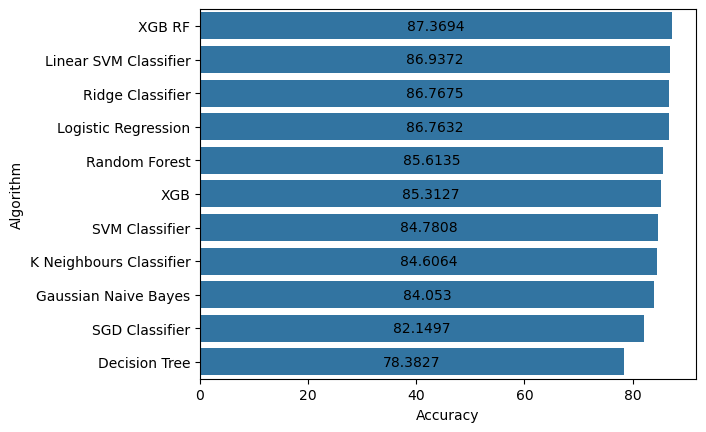

In [65]:
ax = sns.barplot(data=results_df, x='Accuracy', y='Algorithm')
ax.bar_label(ax.containers[0], label_type='center', );

## Feature Selection

In [38]:
from sklearn.feature_selection import mutual_info_classif

pd.DataFrame({
    'Feature': X_train.columns, 
    'MutualInfoValue': mutual_info_classif(X_train, y_train)
}).sort_values(by='MutualInfoValue', ascending=False)

,Feature,MutualInfoValue
1,Sex,0.147806
18,Title_Mr,0.142855
5,Fare,0.132856
19,Title_Mrs,0.087021
6,FamilySize,0.058424
9,FareBin,0.044335
7,Fare_1_49_Perc,0.044294
0,Pclass,0.040284
17,Title_Miss,0.033393
4,Parch,0.027994


In [65]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

rfe = RFECV(estimator=xgb.XGBRFClassifier(), scoring='roc_auc', cv=10, n_jobs=-1)
X_train_rfe = rfe.fit_transform(X_train, y_train)

pd.DataFrame({
    'Feature': X_train.columns,
    'RFE_Rank': rfe.ranking_,
    'RFE_Include': rfe.support_.astype('int')
}).sort_values(by=['RFE_Include', 'RFE_Rank'], ascending=False)

,Feature,RFE_Rank,RFE_Include
0,Pclass,1,1
1,Sex,1,1
6,FamilySize,1,1
10,IsChild,1,1
18,Title_Mr,1,1
20,Title_Rare,1,1
11,IsTeenager,16,0
12,IsAdult,15,0
4,Parch,14,0
16,Embarked_S,13,0


In [40]:
display(cross_val_score(xgbrf, X_train_rfe, y_train, scoring='roc_auc', cv=10, n_jobs=-1).mean() * 100)
display(cross_val_score(xgbrf, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1).mean() * 100)

87.839651416122

87.36938007526243

In [41]:
pd.DataFrame(X_train_rfe, columns=X_train.columns[rfe.support_]).sample(10)

,Pclass,Sex,FamilySize,IsChild,Title_Mr,Title_Rare
523,1.0,1.0,2.0,0.0,0.0,0.0
563,3.0,0.0,1.0,0.0,1.0,0.0
581,1.0,1.0,3.0,0.0,0.0,0.0
859,3.0,0.0,1.0,0.0,1.0,0.0
126,3.0,0.0,1.0,0.0,1.0,0.0
91,3.0,0.0,1.0,0.0,1.0,0.0
761,3.0,0.0,1.0,0.0,1.0,0.0
820,1.0,1.0,3.0,0.0,0.0,0.0
99,2.0,0.0,2.0,0.0,1.0,0.0
845,3.0,0.0,1.0,0.0,1.0,0.0


## Learning curve

In [40]:
def plot_with_err(x, mean, std, ax=None, **kwargs):
    if not ax:
        ax = plt.subplot(111)
    
    lines = ax.plot(x, mean, "-", **kwargs)
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2
    )

def plot_validation_curve_from_cv_results(df, log_features=None):
    param_features = [feat for feat in xgbrf_cv_df.columns if 'param' in feat]
    cols = 2
    rows = int(np.ceil(len(param_features) / cols))
    min_width = 6
    min_height = 4
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * min_width, rows * min_height))
    
    if rows == 1:
        ax = np.array([ax])

    for i, feat in enumerate(param_features):
        row = i // cols
        col = i % 2
        sub_df = (df
                  .loc[:, [feat, 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
                  .groupby(feat, as_index=False)
                  .agg('mean')
                  .sort_values(by=feat))

        plot_with_err(
            x=sub_df[feat],
            mean=sub_df['mean_train_score'],
            std=sub_df['std_train_score'],
            ax=ax[row][col],
            label='Training scores'
        )
        plot_with_err(
            x=sub_df[feat],
            mean=sub_df['mean_test_score'],
            std=sub_df['std_test_score'],
            ax=ax[row][col],
            label='Test scores'
        )

        if log_features and feat in log_features:
            ax[row][col].set_xscale("log")     
        ax[row][col].set_xlabel(feat)
        ax[row][col].set_ylabel("Accuracy")
        ax[row][col].legend()
        ax[row][col].grid(True)

    fig.tight_layout();
    for i, ax_ in enumerate(ax.flat):
        if i >= len(param_features):
            ax_.axis("off")

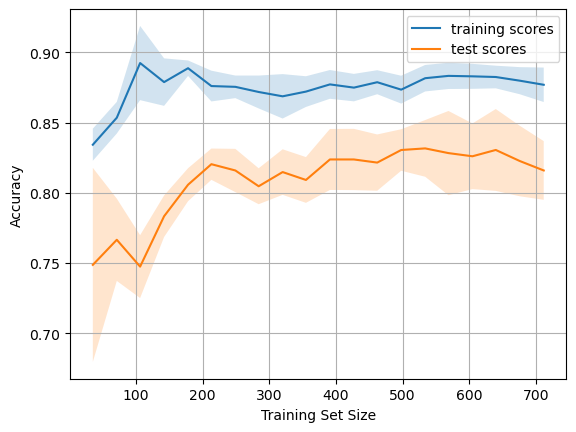

In [41]:
from sklearn.model_selection import learning_curve

train_size_abs, train_scores, test_scores = learning_curve(
    xgb.XGBRFClassifier(),
    X_train,
    y_train,
    train_sizes=np.linspace(0.05, 1, 20),
    cv=5,
    scoring='accuracy'
)

plot_with_err(
    x=train_size_abs,
    mean=train_scores.mean(1),
    std=train_scores.std(1),
    label="training scores"
)
plot_with_err(
    x=train_size_abs,
    mean=test_scores.mean(1),
    std=test_scores.std(1),
    label="test scores"
)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True);

## Parameter tuning

In [29]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [56]:
# from tqdm import tqdm

# class ProgressCallback:
#     def __init__(self):
#         self.pbar = None
#         self.current_iter = 0
#         self.n_iters = None
        
#     def __call__(self, split_idx, n_splits, n_candidates, n_resources):
#         if self.pbar is None:
#             self.n_iters = n_splits * n_candidates
#             self.pbar = tqdm(total=self.n_iters, desc='CV Progress')
#         self.current_iter += 1
#         self.pbar.update(1)
        
#     def close(self):
#         if self.pbar is not None:
#             self.pbar.close()

# class TqdmHalvingGridSearchCV(HalvingGridSearchCV):
#     def fit(self, X, y):
#         self.progress_callback = ProgressCallback()
#         self._run_search = self._make_run_search_with_progress(self._run_search)
#         result = super().fit(X, y)
#         self.progress_callback.close()
#         return result
    
#     def _make_run_search_with_progress(self, original_run_search):
#         def wrapped_run_search(*args, **kwargs):
#             split_idx = kwargs.get('split_idx', 0)
#             n_splits = kwargs.get('n_splits', 1)
#             n_candidates = len(self.param_grid)
#             n_resources = kwargs.get('n_resources', 0)
#             self.progress_callback(split_idx, n_splits, n_candidates, n_resources)
#             return original_run_search(*args, **kwargs)
#         return wrapped_run_search

#### Linear SVM

In [116]:
lsvc_ = LinearSVC(dual='auto', random_state=42)

params = {
    'C': np.logspace(-3, 2, 10),
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'tol': np.logspace(-6, -2, 5),
    'max_iter': [5000, 10000, 15000, 20000, 30000],
}

lsvc_grid = GridSearchCV(lsvc_, params, scoring='accuracy',
                               cv=5, n_jobs=-1, verbose=1, return_train_score=True)

In [ ]:
%%time
lsvc_grid.fit(X_train, y_train)

In [118]:
lsvc_grid.best_params_, lsvc_grid.best_score_

({'C': 100.0,
  'loss': 'hinge',
  'max_iter': 15000,
  'penalty': 'l2',
  'tol': 1e-06},
 0.8260184545853996)

In [119]:
lsvc_grid.best_estimator_.score(X_train, y_train)

0.8282828282828283

#### SVC

##### Regular

In [171]:
svc_ = SVC(probability=False, cache_size=1000, random_state=42, tol=1e-2)

kernel_grids = {
    'linear': {
        'C': np.logspace(-3, 2, 10)
    },
    'poly': {
        'C': np.logspace(-3, 2, 10),
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'coef0': [-10, -5, -3, 0, 3, 5, 10],
    },
    'rbf': {
        'C': np.logspace(-3, 2, 10),
        'gamma': ['scale', 'auto']
    },
    # 'sigmoid': {
    #     'C': np.logspace(-3, 2, 10),
    #     'gamma': ['scale', 'auto'],
    #     'coef0': [-10, -5, -3, 0, 3, 5, 10],
    # }
}

params = [
    {'kernel': ['linear'], **kernel_grids['linear']},
    {'kernel': ['poly'], **kernel_grids['poly']},
    {'kernel': ['rbf'], **kernel_grids['rbf']},
    # {'kernel': ['sigmoid'], **kernel_grids['sigmoid']}
]

svc_grid = HalvingRandomSearchCV(svc_, params, n_candidates=45, min_resources='exhaust', scoring='accuracy', factor=1.1,
                               cv=5, n_jobs=-1, verbose=1, random_state=42, return_train_score=True)

In [172]:
%%time
svc_grid.fit(X_train, y_train)

n_iterations: 40
n_required_iterations: 40
n_possible_iterations: 40
min_resources_: 21.0
max_resources_: 891
aggressive_elimination: False
factor: 1.1
----------
iter: 0
n_candidates: 45
n_resources: 21
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 1
n_candidates: 41
n_resources: 23
Fitting 5 folds for each of 41 candidates, totalling 205 fits
----------
iter: 2
n_candidates: 38
n_resources: 25
Fitting 5 folds for each of 38 candidates, totalling 190 fits
----------
iter: 3
n_candidates: 35
n_resources: 27
Fitting 5 folds for each of 35 candidates, totalling 175 fits
----------
iter: 4
n_candidates: 32
n_resources: 30
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 5
n_candidates: 30
n_resources: 33
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 6
n_candidates: 28
n_resources: 37
Fitting 5 folds for each of 28 candidates, totalling 140 fits
----------
iter: 7
n_candidates: 26
n_resources: 4

HalvingRandomSearchCV(estimator=SVC(cache_size=1000, random_state=42, tol=0.01),
                      factor=1.1, min_resources='exhaust', n_candidates=45,
                      n_jobs=-1,
                      param_distributions=[{'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                            'kernel': ['linear']},
                                           {'C':...
       2.78255940e+01, 1.00000000e+02]),
                                            'coef0': [-10, -5, -3, 0, 3, 5, 10],
                                            'degree': [2, 3, 4],
                                            'gamma': ['scale', 'auto'],
                                            'kernel': ['poly']},
                                           {'C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                            'gamma': ['scale', 'auto'],
                                            'kernel': ['rbf']}],
                      random_state=42, scoring='accuracy', verbose=1)

In [173]:
svc_grid.best_params_, svc_grid.best_score_

({'kernel': 'poly',
  'gamma': 'scale',
  'degree': 3,
  'coef0': 5,
  'C': 0.1668100537200059},
 0.8327261728726979)

In [174]:
svc_grid.best_estimator_.score(X_train, y_train)

0.8361391694725028

#### Decision Tree

In [52]:
dt_ = DecisionTreeClassifier(random_state=42)
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + [3, 4, 6, 8, 10, 14, 20],
    'min_samples_split': [2, 5, 10, 30, 50],
    'min_samples_leaf': [1, 3, 5, 10, 30],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 8, 16, 32, 64]
}
dt_grid = GridSearchCV(estimator=dt_, param_grid=params, scoring='accuracy', 
                               cv=5, n_jobs=-1, verbose=1)

##### Regular

In [53]:
%%time
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18000 candidates, totalling 90000 fits
CPU times: user 21.9 s, sys: 408 ms, total: 22.3 s
Wall time: 1min 23s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 4, 6, 8, 10, 14, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 3, 5, 10, 30],
                         'min_samples_split': [2, 5, 10, 30, 50],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [54]:
dt_grid.best_params_, dt_grid.best_score_

({'criterion': 'entropy',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 64,
  'min_samples_leaf': 10,
  'min_samples_split': 30,
  'splitter': 'best'},
 0.8305316678174629)

In [55]:
dt_grid.best_estimator_.score(X_train, y_train)

0.8653198653198653

##### RFE

In [56]:
%%time
dt_grid.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 18000 candidates, totalling 90000 fits
CPU times: user 18.9 s, sys: 168 ms, total: 19.1 s
Wall time: 42.7 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 4, 6, 8, 10, 14, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 8, 16, 32, 64],
                         'min_samples_leaf': [1, 3, 5, 10, 30],
                         'min_samples_split': [2, 5, 10, 30, 50],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [57]:
dt_grid.best_params_, dt_grid.best_score_

({'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': 16,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'splitter': 'best'},
 0.8316238779737619)

In [59]:
dt_grid.best_estimator_.score(X_train_rfe, y_train)

0.8372615039281706

#### XGB

In [171]:
xgbc_ = xgb.XGBClassifier(booster='gbtree', colsample_bylevel=1, colsample_bynode=1, eval_metric='error', n_jobs=-1, random_state=42)
params = {
    'n_estimators': np.arange(100, 1100, step=100),
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': np.linspace(0, 5, 10),
    'reg_alpha': np.logspace(-3, 0, 5),
    'reg_lambda': np.logspace(-3, 1, 5),
    'grow_policy': ['depthwise', 'lossguide'],
    'max_leaves': np.logspace(1, 6, num=6, base=2, dtype='int'),
    'max_delta_step': np.logspace(-4, 0, num=10),
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1]
}
rand_grid = RandomizedSearchCV(estimator=xgbc_, param_distributions=params, scoring='accuracy',
                               n_iter=10000, cv=5, n_jobs=-1, random_state=42, verbose=1)

In [172]:
%%time
rand_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
CPU times: user 1min 4s, sys: 2.22 s, total: 1min 6s
Wall time: 13min 23s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
       3.59381366e-01, 1.00000000e+00]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'max_leaves': array([ 2,  4,  8, 16, 32, 64]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'reg_alpha': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                                        'reg_lambda': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [173]:
rand_grid.best_params_, rand_grid.best_score_

({'subsample': 0.9,
  'reg_lambda': 0.01,
  'reg_alpha': 0.005623413251903491,
  'n_estimators': 900,
  'max_leaves': 16,
  'max_depth': 10,
  'max_delta_step': 1.0,
  'learning_rate': 0.1711111111111111,
  'grow_policy': 'lossguide',
  'gamma': 1.6666666666666667,
  'colsample_bytree': 0.8},
 0.832772581758835)

In [167]:
rand_grid.best_estimator_.score(X_train, y_train)

0.8451178451178452

#### XGB RF

In [34]:
xgbrf_ = xgb.XGBRFClassifier(subsample=0.8, n_estimators=50, colsample_bynode=0.7, random_state=42, n_jobs=-1)
params = {
    'learning_rate': [1e-4, 1e-2, 1],
    'reg_alpha': [0.5, 4, 6],
    'reg_lambda': [2, 6, 10],
    'colsample_bytree': [0.4, 0.8, 1],
    'colsample_bylevel': [0.4, 0.8, 1],
    'grow_policy': ['depthwise', 'lossguide'],
    'gamma': np.logspace(-3, 1, 5),
    'max_depth': [None, 2, 4],
    'max_leaves': [None, 8, 16, 32]
}

xgbrf_grid = HalvingGridSearchCV(estimator=xgbrf_, param_grid=params, scoring='accuracy', factor=3, min_resources=230,
                               cv=5, n_jobs=-1, verbose=1, return_train_score=True)

##### Regular

In [35]:
%%time
xgbrf_grid.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 10
n_possible_iterations: 2
min_resources_: 230
max_resources_: 891
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 29160
n_resources: 230
Fitting 5 folds for each of 29160 candidates, totalling 145800 fits
----------
iter: 1
n_candidates: 9720
n_resources: 690
Fitting 5 folds for each of 9720 candidates, totalling 48600 fits
CPU times: user 3min 19s, sys: 4.37 s, total: 3min 24s
Wall time: 18min 34s


HalvingGridSearchCV(estimator=XGBRFClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              max_bin=None,
                                              max...
                    min_resources=230, n_jobs=-1,
                    param_grid={'colsample_bylevel': [0.4, 0.8, 1],
                                'colsample_bytree': [0.4, 0.8, 1],
                                'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                'grow_policy': ['depthwise', 'lossguide'],
                                'learning_rate': [0.0001, 0.01, 1],
                                'max_depth': [None, 2, 4],
                                'max_leaves': [None, 8, 16, 32],
                                'reg_alpha': [0.5, 4, 6],
                                'reg_lambda': [2, 6, 10]},
                    scoring='accuracy', verbose=1)

In [36]:
xgbrf_grid.best_params_, xgbrf_grid.best_score_

({'colsample_bylevel': 1,
  'colsample_bytree': 0.8,
  'gamma': 0.001,
  'grow_policy': 'lossguide',
  'learning_rate': 1,
  'max_depth': 4,
  'max_leaves': 8,
  'reg_alpha': 4,
  'reg_lambda': 2},
 0.841161536020311)

In [51]:
cv_results_features = ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']
params_features = ['param_' + param_name for param_name in xgbrf_grid.cv_results_['params'][0].keys()]
xgbrf_cv_df = pd.DataFrame(xgbrf_grid.cv_results_)[cv_results_features + params_features]

non_num_feat = ['param_grow_policy']
num_feat = [feat for feat in params_features if feat not in non_num_feat]
# fillna(-1) for when None from grid is replaces by NaN
xgbrf_cv_df[num_feat] = xgbrf_cv_df[num_feat].astype('float').fillna(-1)
xgbrf_cv_df.head()

,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_grow_policy,param_learning_rate,param_max_depth,param_max_leaves,param_reg_alpha,param_reg_lambda
0,0.602851,0.029075,0.632367,0.051925,18057,0.4,0.4,0.001,depthwise,0.0001,-1.0,-1.0,0.5,2.0
1,0.602851,0.029075,0.632367,0.051925,18057,0.4,0.4,0.001,depthwise,0.0001,-1.0,-1.0,0.5,6.0
2,0.602851,0.029075,0.632367,0.051925,18057,0.4,0.4,0.001,depthwise,0.0001,-1.0,-1.0,0.5,10.0
3,0.602851,0.029075,0.632367,0.051925,18057,0.4,0.4,0.001,depthwise,0.0001,-1.0,-1.0,4.0,2.0
4,0.602851,0.029075,0.632367,0.051925,18057,0.4,0.4,0.001,depthwise,0.0001,-1.0,-1.0,4.0,6.0


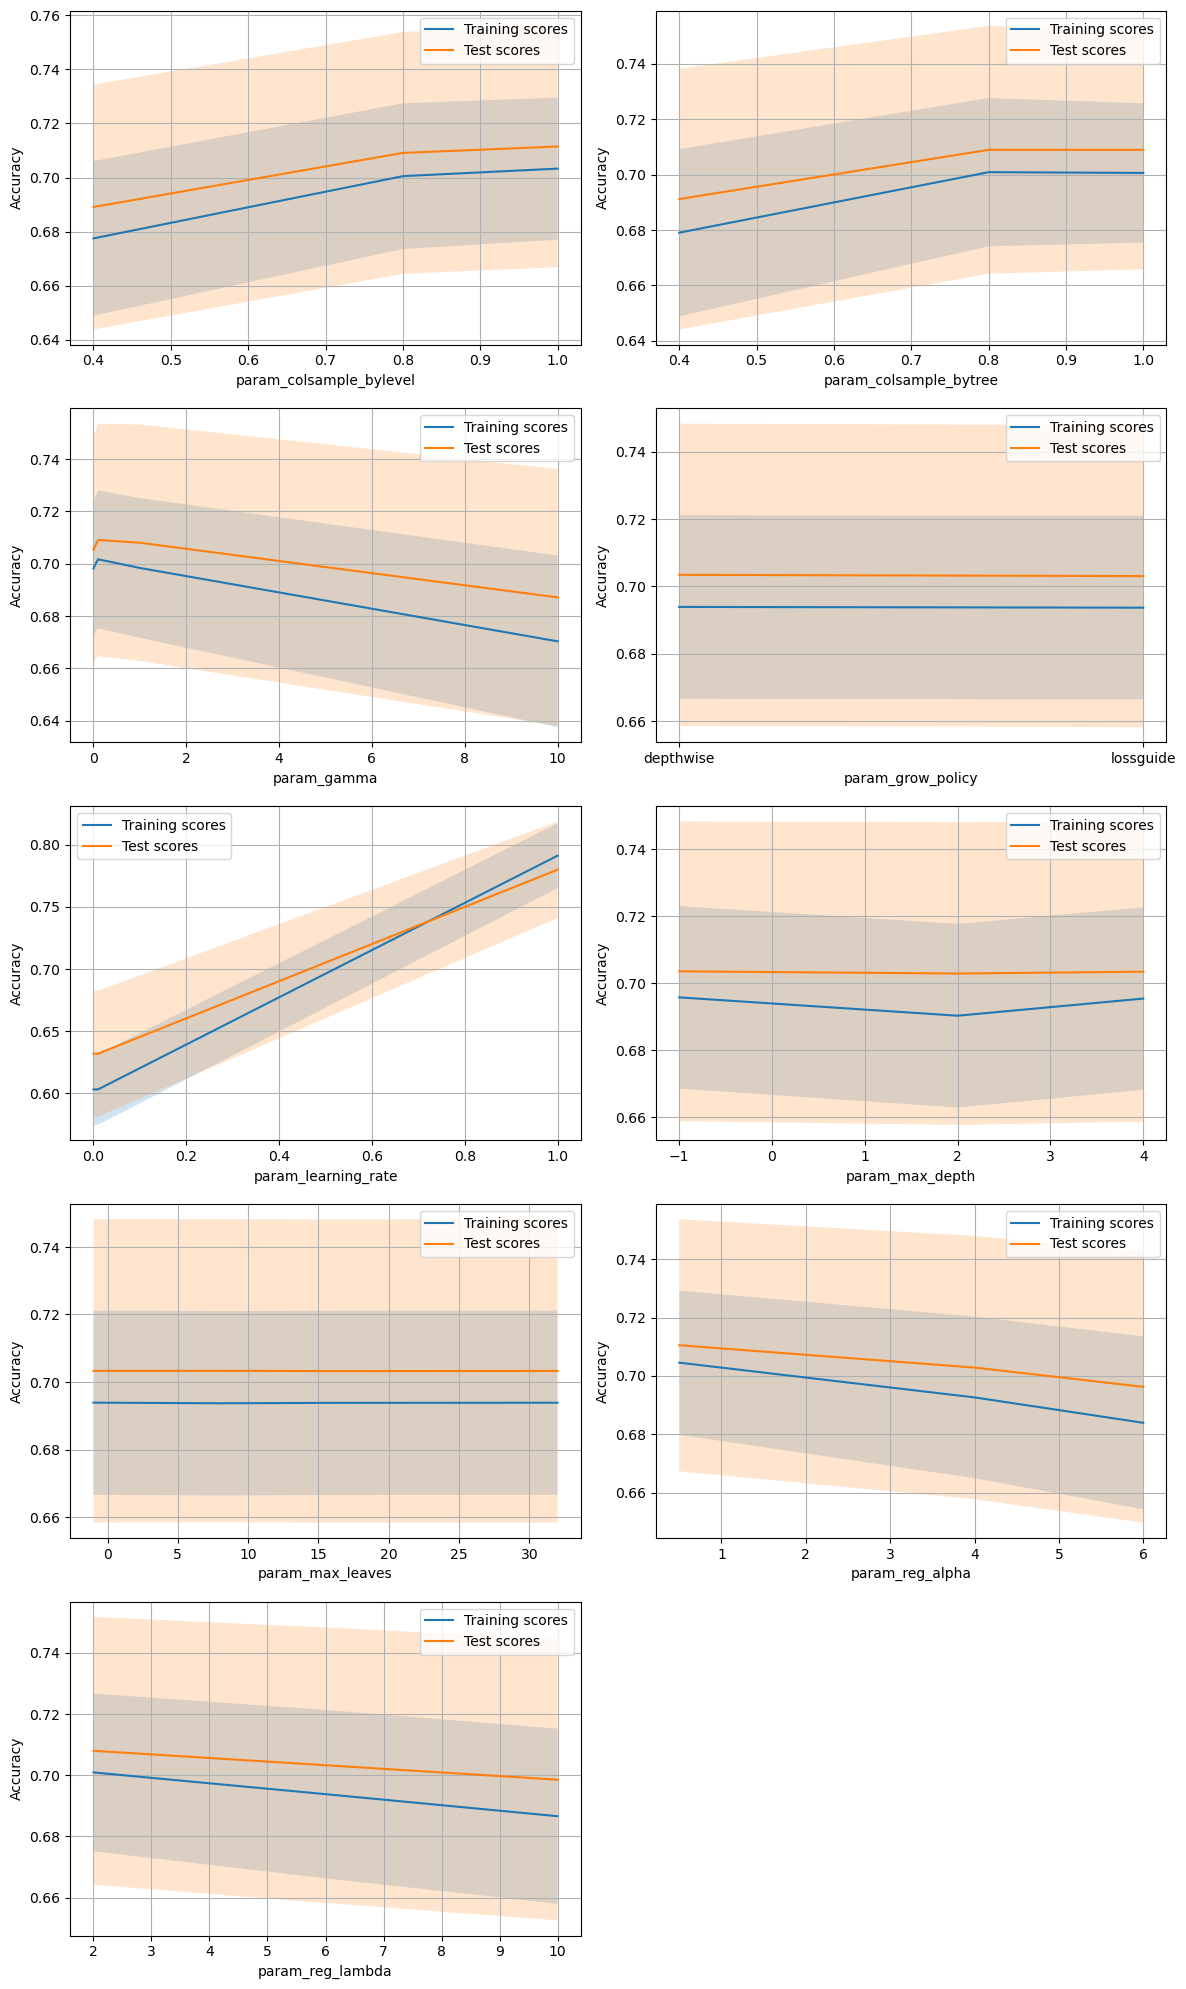

In [52]:
plot_validation_curve_from_cv_results(xgbrf_cv_df, ['learning_rate', 'reg_alpha', 'reg_lambda'])

In [53]:
xgbrf_grid.best_params_, xgbrf_grid.best_score_

({'colsample_bylevel': 1,
  'colsample_bytree': 0.8,
  'gamma': 0.001,
  'grow_policy': 'lossguide',
  'learning_rate': 1,
  'max_depth': 4,
  'max_leaves': 8,
  'reg_alpha': 4,
  'reg_lambda': 2},
 0.841161536020311)

In [54]:
xgbrf_grid.best_estimator_.score(X_train, y_train)

0.8361391694725028

In [66]:
xgbrf_.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=0.7,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=50, n_jobs=-1,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=42, ...)

##### RFE

In [44]:
%%time
xgbrf_grid.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits
CPU times: user 29.2 s, sys: 315 ms, total: 29.5 s
Wall time: 3min 16s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bynode': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 150, 200],
                         'reg_alpha': [0, 0.1, 1, 10],
                         'reg_lambda': [0.5, 1, 5, 10],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [45]:
xgbrf_grid.best_params_, xgbrf_grid.best_score_

({'colsample_bynode': 0.7,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 150,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'subsample': 1.0},
 0.8349946644906158)

## Submission

In [61]:
def write_pred_to_file(y_pred: np.ndarray, file_name: str) -> None:
    submission = pd.DataFrame({
        "PassengerId": X_test.index,
        "Survived": y_pred
    })
    submission.to_csv(DATA_DIR + file_name, index=False)

In [62]:
y_pred = xgbrf.best_estimator_.predict(X_test)
write_pred_to_file(y_pred, file_name='submission_xgb_rf.csv')